In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from baukit import nethook
from operator import itemgetter

In [7]:
MODEL_NAME = "EleutherAI/gpt-j-6B" # "facebook/galactica-6.7b"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
n_embd_field = "hidden_size"
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 12219206136


In [9]:
with open("data/comperative-superlative.txt") as f:
    lines = f.readlines()
    words = []
    for line in lines:
        w = line.strip()
        if(len(w) == 0):
            continue
        words.append(w)

base = words[0 : len(words) : 3]
comparative = words[1 : len(words) : 3]
superlative = words[2 : len(words) : 3]

list(zip(base, comparative, superlative))

[('angry', 'angrier', 'angriest'),
 ('bad', 'worse', 'worst'),
 ('big', 'bigger', 'biggest'),
 ('bitter', 'bitterer', 'bitterest'),
 ('black', 'blacker', 'blackest'),
 ('bland', 'blander', 'blandest'),
 ('bloody', 'bloodier', 'bloodiest'),
 ('blue', 'bluer', 'bluest'),
 ('bold', 'bolder', 'boldest'),
 ('bossy', 'bossier', 'bossiest'),
 ('brave', 'braver', 'bravest'),
 ('brief', 'briefer', 'briefest'),
 ('bright', 'brighter', 'brightest'),
 ('broad', 'broader', 'broadest'),
 ('busy', 'busier', 'busiest'),
 ('calm', 'calmer', 'calmest'),
 ('cheap', 'cheaper', 'cheapest'),
 ('chewy', 'chewier', 'chewiest'),
 ('chubby', 'chubbier', 'chubbiest'),
 ('classy', 'classier', 'classiest'),
 ('clean', 'cleaner', 'cleanest'),
 ('clear', 'clear', 'clearest'),
 ('clever', 'cleverer', 'cleverest'),
 ('close', 'closer', 'closest'),
 ('cloudy', 'cloudier', 'cloudiest'),
 ('clumsy', 'clumsier', 'clumsiest'),
 ('coarse', 'coarser', 'coarsest'),
 ('cold', 'colder', 'coldest'),
 ('cool', 'cooler', 'coolest'

In [10]:
tokenizer([' class', ' classy', ' classier', ' classiest'], padding=True, return_tensors='pt')

{'input_ids': tensor([[ 1398, 50256],
        [48486, 50256],
        [ 1398,   959],
        [ 1398,  6386]]), 'attention_mask': tensor([[1, 0],
        [1, 0],
        [1, 1],
        [1, 1]])}

In [11]:
filter_single_token = []
for b, c, s in zip(base, comparative, superlative):
    tokenized = tokenizer([" " + b, " " + c, " " + s], padding=True, return_tensors='pt').input_ids
    if(tokenized.shape[1] > 1):
        continue
    filter_single_token.append((b, c, s))
filter_single_token

[('bad', 'worse', 'worst'),
 ('big', 'bigger', 'biggest'),
 ('bright', 'brighter', 'brightest'),
 ('cheap', 'cheaper', 'cheapest'),
 ('close', 'closer', 'closest'),
 ('cool', 'cooler', 'coolest'),
 ('dark', 'darker', 'darkest'),
 ('deep', 'deeper', 'deepest'),
 ('early', 'earlier', 'earliest'),
 ('easy', 'easier', 'easiest'),
 ('fast', 'faster', 'fastest'),
 ('fine', 'finer', 'finest'),
 ('full', 'fuller', 'fullest'),
 ('good', 'better', 'best'),
 ('great', 'greater', 'greatest'),
 ('happy', 'happier', 'happiest'),
 ('hard', 'harder', 'hardest'),
 ('heavy', 'heavier', 'heaviest'),
 ('high', 'higher', 'highest'),
 ('hot', 'hotter', 'hottest'),
 ('large', 'larger', 'largest'),
 ('late', 'later', 'latest'),
 ('long', 'longer', 'longest'),
 ('low', 'lower', 'lowest'),
 ('near', 'nearer', 'nearest'),
 ('new', 'newer', 'newest'),
 ('poor', 'poorer', 'poorest'),
 ('quick', 'quicker', 'quickest'),
 ('rich', 'richer', 'richest'),
 ('safe', 'safer', 'safest'),
 ('short', 'shorter', 'shortest'),


In [13]:
prompt = """superlative of late is latest
superlative of strong is strongest
superlaitve of {} is"""

# prompt = """grape ends with E
# monitor ends with R
# glass ends with"""

words = ['strong', 'big', 'deep', 'young']

for w in words:
    txt, ret_dict = model_utils.generate_fast(
        model, tokenizer, 
        prompts=[prompt.format(w)], max_new_tokens=10, 
        get_answer_tokens=True, argmax_greedy=True
    )
    print(f"{w} ===> {ret_dict['answer'][0]['top_token']}")


strong ===>  strongest
big ===>  biggest
deep ===>  deepest
young ===>  youngest


In [15]:
objects = [" " + o[2] for o in filter_single_token]

from relations.corner import CornerEstimator
corner_estimator = CornerEstimator(
    model=model, tokenizer=tokenizer,
    # ln_f_name= "model.decoder.final_layer_norm", 
    # unembedder_module_name="lm_head"
)

In [16]:
simple_corner = corner_estimator.estimate_simple_corner(objects, scale_up=70)
print(simple_corner.norm().item(), corner_estimator.get_vocab_representation(simple_corner, get_logits=True))

51.53125 [(' largest', 104.312), (' highest', 103.062), (' longest', 99.688), (' strongest', 99.375), (' smallest', 99.125)]


In [18]:
# print(-simple_corner.norm().item(), corner_estimator.get_vocab_representation(-simple_corner, get_logits=True))

In [19]:
lin_inv_corner = corner_estimator.estimate_lin_inv_corner(objects, target_logit_value=50)
print(lin_inv_corner.norm().item(), corner_estimator.get_vocab_representation(lin_inv_corner, get_logits=True))

calculating inverse of unbedding weights . . .
48.71875 [(' strongest', 74.875), (' fastest', 73.938), (' longest', 73.375), (' largest', 72.0), (' smallest', 70.562)]


In [21]:
lst_sq_corner = corner_estimator.estimate_corner_lstsq_solve(objects[:15], target_logit=30)
print(lst_sq_corner.norm().item(), corner_estimator.get_vocab_representation(lst_sq_corner, get_logits=True))

39.90625 [(' highest', 88.875), (' largest', 88.625), (' best', 88.5), (' closest', 88.312), (' worst', 88.062)]


In [29]:
grad_dsc_corner = corner_estimator.estimate_corner_with_gradient_descent(objects, target_logit_value=50, verbose=False)
print(grad_dsc_corner.norm().item(), corner_estimator.get_vocab_representation(grad_dsc_corner, get_logits=True))

/home/local_arnab/Codes/relations/notebooks/../relations/corner.py:159: UserWarning: 
                model.dtype == torch.float16
                the unembedder head will be typecasted to float32 in order to avoid precision underflows.
                
  


49.5 [(' oldest', 53.219), (' richest', 51.906), (' closest', 50.969), (' fastest', 50.75), (' smallest', 50.531)]


In [30]:
def check_with_test_cases(relation_operator):
    test_cases = [
        (b, -1, s) for b, c, s in filter_single_token[15:]
    ]
    # print(test_cases)
    for subject, subject_token_index, target in test_cases:
        answer = relation_operator(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {answer}")

In [31]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = prompt,
    layer = 15, 
    # layer_name_format = "model.decoder.layers.{}",
    weight = torch.eye(getattr(model.config, n_embd_field)).to(model.dtype).to(model.device),
    bias = grad_dsc_corner,

    # ln_f_name = "model.decoder.final_layer_norm"
)

check_with_test_cases(relation)

happy, target: happiest   ==>   predicted: [' smallest', ' best', ' tallest', ' largest', ' biggest']
hard, target: hardest   ==>   predicted: [' smallest', ' lowest', ' closest', ' largest', ' cheapest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' lowest', ' smallest', ' largest', ' best']
high, target: highest   ==>   predicted: [' tallest', ' largest', ' smallest', ' best', ' greatest']
hot, target: hottest   ==>   predicted: [' largest', ' lowest', ' highest', ' best', ' tallest']
large, target: largest   ==>   predicted: [' smallest', ' best', ' greatest', ' lowest', ' largest']
late, target: latest   ==>   predicted: [' greatest', ' smallest', ' largest', ' lowest', ' worst']
long, target: longest   ==>   predicted: [' tallest', ' largest', ' smallest', ' greatest', ' lowest']
low, target: lowest   ==>   predicted: [' tallest', ' smallest', ' greatest', ' largest', ' best']
near, target: nearest   ==>   predicted: [' smallest', ' least', ' tallest', ' largest', ' l

In [47]:
def get_averaged_JB(top_performers, relation_prompt, num_icl = 3, calculate_at_lnf = False):
    try:
        jbs = []
        for s, s_idx, o in tqdm(top_performers):
            others = set(top_performers) - {(s, s_idx, o)}
            others = random.sample(list(others), k = min(num_icl, len(list(others)))) 
            prompt = ""
            prompt += "\n".join(relation_prompt.format(s_other) + f" {o_other}." for s_other, idx_other, o_other in others) + "\n"
            prompt += relation_prompt
            print("subject: ", s)
            print(prompt)

            jb, _ = estimate.relation_operator_from_sample(
                model, tokenizer,
                s, prompt,
                subject_token_index= s_idx,
                layer = 15,
                device = model.device,
                # calculate_at_lnf = calculate_at_lnf,
                # layer_name_format = "model.decoder.layers.{}",
                # ln_f_name = "model.decoder.final_layer_norm",
                # n_layer_field = "num_hidden_layers"
            )
            print(jb.weight.norm(), jb.bias.norm())
            print()
            jbs.append(jb)
        
        weight = torch.stack([jb.weight for jb in jbs]).mean(dim=0)
        bias  = torch.stack([jb.bias for jb in jbs]).mean(dim=0)

        return weight, bias
    except RuntimeError as e:
        if(str(e).startswith("CUDA out of memory")):
            print("CUDA out of memory")
        if(num_icl > 1):
            num_icl -= 1
            print("trying with smaller icl >> ", num_icl)
            return get_averaged_JB(top_performers, relation_prompt, num_icl, calculate_at_lnf)
        else:
            raise Exception("RuntimeError >> can't calculate Jacobian with minimum number of icl examples")

def get_multiple_averaged_JB(top_performers, relation_prompt, N = 3, num_icl = 2, calculate_at_lnf = False):
    weights_and_biases = []
    sample_size = min(len(top_performers), num_icl + 2)
    for _ in tqdm(range(N)):
        cur_sample = random.sample(top_performers, k = sample_size)
        weight, bias = get_averaged_JB(cur_sample, relation_prompt, num_icl, calculate_at_lnf)
        weights_and_biases.append({
            'weight': weight,
            'bias'  : bias
        })
    return weights_and_biases

In [48]:
samples = [
        (b, -1, s) for b, c, s in filter_single_token[:10]
    ]
print(samples)

weights_and_biases = get_multiple_averaged_JB(
    samples, 
    relation_prompt="superlative of {} is", 
    N = 3, 
    calculate_at_lnf=False
)

[('bad', -1, 'worst'), ('big', -1, 'biggest'), ('bright', -1, 'brightest'), ('cheap', -1, 'cheapest'), ('close', -1, 'closest'), ('cool', -1, 'coolest'), ('dark', -1, 'darkest'), ('deep', -1, 'deepest'), ('early', -1, 'earliest'), ('easy', -1, 'easiest')]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  close
superlative of early is earliest.
superlative of bright is brightest.
superlative of {} is
tensor(34.2500, device='cuda:0', dtype=torch.float16) tensor(308.7500, device='cuda:0', dtype=torch.float16)

subject:  dark
superlative of close is closest.
superlative of bright is brightest.
superlative of {} is
tensor(28.5781, device='cuda:0', dtype=torch.float16) tensor(252.1250, device='cuda:0', dtype=torch.float16)

subject:  bright
superlative of dark is darkest.
superlative of close is closest.
superlative of {} is
tensor(29.7656, device='cuda:0', dtype=torch.float16) tensor(298., device='cuda:0', dtype=torch.float16)

subject:  early
superlative of dark is darkest.
superlative of close is closest.
superlative of {} is
tensor(34.7500, device='cuda:0', dtype=torch.float16) tensor(302.2500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  close
superlative of early is earliest.
superlative of dark is darkest.
superlative of {} is
tensor(32.5312, device='cuda:0', dtype=torch.float16) tensor(307.7500, device='cuda:0', dtype=torch.float16)

subject:  cheap
superlative of early is earliest.
superlative of close is closest.
superlative of {} is
tensor(30.8906, device='cuda:0', dtype=torch.float16) tensor(304., device='cuda:0', dtype=torch.float16)

subject:  dark
superlative of close is closest.
superlative of cheap is cheapest.
superlative of {} is
tensor(32.5625, device='cuda:0', dtype=torch.float16) tensor(277.7500, device='cuda:0', dtype=torch.float16)

subject:  early
superlative of close is closest.
superlative of cheap is cheapest.
superlative of {} is
tensor(34.9375, device='cuda:0', dtype=torch.float16) tensor(287.2500, device='cuda:0', dtype=torch.float16)



  0%|          | 0/4 [00:00<?, ?it/s]

subject:  early
superlative of big is biggest.
superlative of bright is brightest.
superlative of {} is
tensor(35.6875, device='cuda:0', dtype=torch.float16) tensor(297.2500, device='cuda:0', dtype=torch.float16)

subject:  big
superlative of early is earliest.
superlative of bright is brightest.
superlative of {} is
tensor(28.6406, device='cuda:0', dtype=torch.float16) tensor(276.7500, device='cuda:0', dtype=torch.float16)

subject:  bright
superlative of bad is worst.
superlative of early is earliest.
superlative of {} is
tensor(30.4062, device='cuda:0', dtype=torch.float16) tensor(262., device='cuda:0', dtype=torch.float16)

subject:  bad
superlative of big is biggest.
superlative of bright is brightest.
superlative of {} is
tensor(31.9062, device='cuda:0', dtype=torch.float16) tensor(290.7500, device='cuda:0', dtype=torch.float16)



In [49]:
'shortest' in objects[:30]

False

In [50]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0),
    # bias = torch.stack(
    #     [wb['bias'] for wb in weights_and_biases]
    # ).mean(dim=0),
    bias = grad_dsc_corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' happiest', ' best', ' quickest', ' happy', ' richest']
hard, target: hardest   ==>   predicted: [' hardest', ' toughest', ' easiest', ' strongest', ' closest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' darkest', ' hardest', ' strongest', ' worst']
high, target: highest   ==>   predicted: [' highest', ' tallest', ' lowest', ' richest', ' cheapest']
hot, target: hottest   ==>   predicted: [' hottest', ' coolest', ' fastest', ' quickest', ' worst']
large, target: largest   ==>   predicted: [' largest', ' biggest', ' widest', ' smallest', ' greatest']
late, target: latest   ==>   predicted: [' latest', ' newest', ' oldest', ' earliest', ' longest']
long, target: longest   ==>   predicted: [' longest', ' shortest', ' oldest', ' tallest', ' earliest']
low, target: lowest   ==>   predicted: [' lowest', ' poorest', ' cheapest', ' weakest', ' smallest']
near, target: nearest   ==>   predicted: [' nearest', ' closest', ' oldest', ' n

In [51]:
corner_estimator.get_vocab_representation(
    torch.stack(
        [wb['bias'] for wb in weights_and_biases]
    ).mean(dim=0), get_logits=True
)

[(' most', 20.312),
 ('\n', 19.234),
 (' the', 19.109),
 (' least', 17.797),
 (' ', 16.922)]

In [56]:
from relations.utils import visualize_matrix, low_rank_approximation

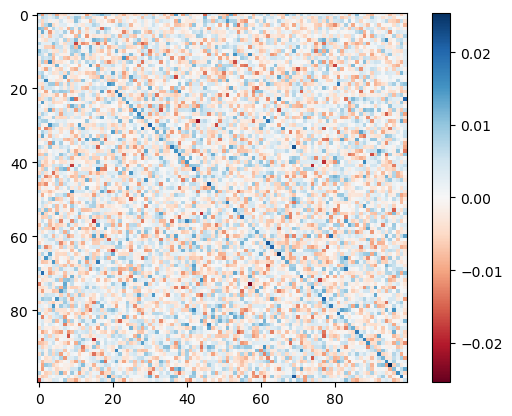

In [57]:
mean_jacobian = torch.stack(
        [wb['weight'] for wb in weights_and_biases]
    ).mean(dim=0)

visualize_matrix(mean_jacobian)

rank 300 >>  tensor(60.8318, device='cuda:0')


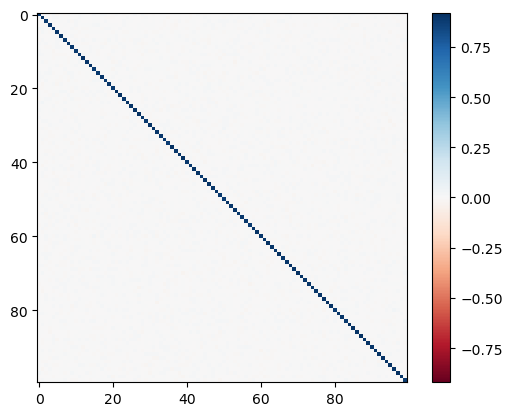

In [70]:
I = torch.eye(model.config.n_embd).to(model.dtype).to(model.device)
residual_add = mean_jacobian - I

residual_add_approx = low_rank_approximation(residual_add, rank = 300)
jacobian_approx = I + residual_add_approx
visualize_matrix(jacobian_approx)

In [71]:
relation_operator = estimate.RelationOperator(
    model = model,
    tokenizer= tokenizer,
    relation = prompt,
    layer = 15,
    weight = jacobian_approx,
    bias = grad_dsc_corner,

    # layer_name_format = "model.decoder.layers.{}",
    # ln_f_name = "model.decoder.final_layer_norm",
)

check_with_test_cases(relation_operator)

happy, target: happiest   ==>   predicted: [' happiest', ' quickest', ' fastest', ' best', ' richest']
hard, target: hardest   ==>   predicted: [' hardest', ' closest', ' poorest', ' fastest', ' smallest']
heavy, target: heaviest   ==>   predicted: [' heaviest', ' lowest', ' largest', ' hardest', ' highest']
high, target: highest   ==>   predicted: [' tallest', ' highest', ' largest', ' greatest', ' best']
hot, target: hottest   ==>   predicted: [' hottest', ' highest', ' fastest', ' largest', ' quickest']
large, target: largest   ==>   predicted: [' largest', ' smallest', ' biggest', ' greatest', ' tallest']
late, target: latest   ==>   predicted: [' latest', ' largest', ' longest', ' newest', ' lowest']
long, target: longest   ==>   predicted: [' longest', ' tallest', ' shortest', ' largest', ' oldest']
low, target: lowest   ==>   predicted: [' lowest', ' poorest', ' smallest', ' tallest', ' least']
near, target: nearest   ==>   predicted: [' nearest', ' smallest', ' least', ' talles